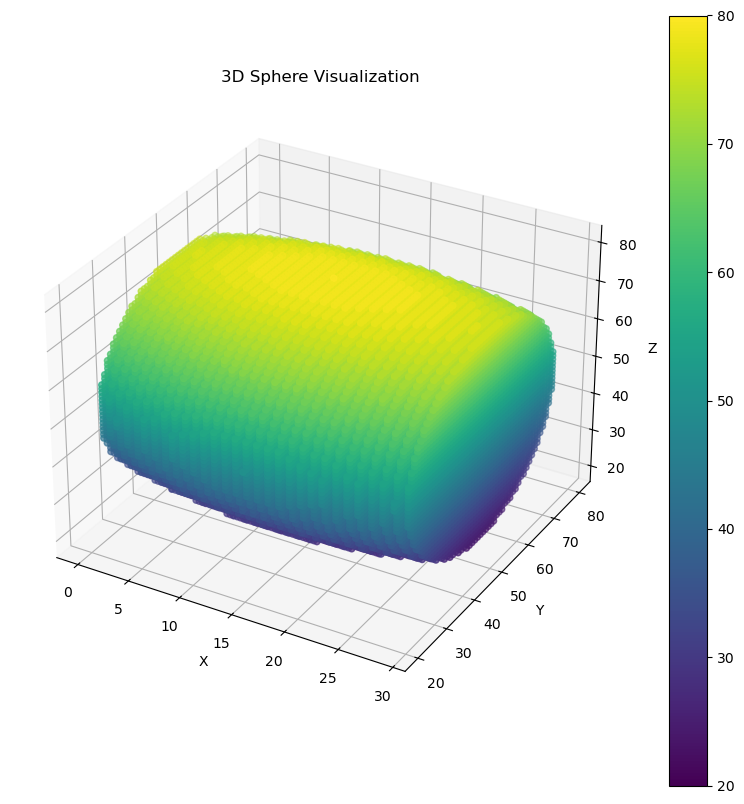

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D array (30x30x30) with a sphere pattern
x, y, z = np.indices((30, 100, 100))
center = (15, 50, 50)
radius = 30
sphere = (x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 <= radius**2
data = np.zeros((30, 100, 100))
data[sphere] = 1

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Get the voxel coordinates where value is 1
x, y, z = data.nonzero()

# Plot the 3D points
scatter = ax.scatter(x, y, z, c=z, cmap='viridis')
plt.colorbar(scatter)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Sphere Visualization')

# Show the plot
plt.show()


In [49]:
data.shape

(30, 100, 100)

In [60]:
import numpy as np

def segment_3d_with_coordinates(data, depth_size=15, height_size=50, width_size=50):
    """
    Segments 3D data and returns both segments and their coordinates
    
    Returns:
        main_segments: list of regular-sized segments
        main_coordinates: list of (d_start, d_end, h_start, h_end, w_start, w_end)
        leftover_segments: list of leftover segments
        leftover_coordinates: list of coordinates for leftover segments
    """
    depth, height, width = data.shape
    
    n_depth = depth // depth_size
    n_height = height // height_size
    n_width = width // width_size
    
    main_segments = []
    main_coordinates = []
    leftover_segments = []
    leftover_coordinates = []
    
    # Extract main segments with coordinates
    for d in range(n_depth):
        for h in range(n_height):
            for w in range(n_width):
                d_start = d * depth_size
                d_end = (d + 1) * depth_size
                h_start = h * height_size
                h_end = (h + 1) * height_size
                w_start = w * width_size
                w_end = (w + 1) * width_size
                
                segment = data[d_start:d_end, h_start:h_end, w_start:w_end]
                main_segments.append(segment)
                main_coordinates.append((d_start, d_end, h_start, h_end, w_start, w_end))
    
    # Handle leftover in depth
    if depth % depth_size != 0:
        d_start = n_depth * depth_size
        d_end = depth
        h_end = height_size * n_height
        w_end = width_size * n_width
        
        leftover_d = data[d_start:d_end, :h_end, :w_end]
        if leftover_d.size > 0:
            leftover_segments.append(leftover_d)
            leftover_coordinates.append((d_start, d_end, 0, h_end, 0, w_end))
    
    # Handle leftover in height
    if height % height_size != 0:
        d_end = depth_size * n_depth
        h_start = height_size * n_height
        h_end = height
        w_end = width_size * n_width
        
        leftover_h = data[:d_end, h_start:h_end, :w_end]
        if leftover_h.size > 0:
            leftover_segments.append(leftover_h)
            leftover_coordinates.append((0, d_end, h_start, h_end, 0, w_end))
    
    # Handle leftover in width
    if width % width_size != 0:
        d_end = depth_size * n_depth
        h_end = height_size * n_height
        w_start = width_size * n_width
        w_end = width
        
        leftover_w = data[:d_end, :h_end, w_start:w_end]
        if leftover_w.size > 0:
            leftover_segments.append(leftover_w)
            leftover_coordinates.append((0, d_end, 0, h_end, w_start, w_end))
    
    return main_segments, main_coordinates, leftover_segments, leftover_coordinates

# Example usage
if __name__ == "__main__":
    # Create sample data
    
    # Segment the data
    main_segments, main_coords, leftover_segments, leftover_coords = segment_3d_with_coordinates(
        data, 
        depth_size=15, 
        height_size=50, 
        width_size=50
    )
    
    # Print results
    print(f"Original data shape: {data.shape}")
    print(f"Number of main segments: {len(main_segments)}")
    print("\nMain segment coordinates:")
    for i, coords in enumerate(main_coords):
        print(f"Segment {i}: {coords}")
    
    print("\nLeftover segment coordinates:")
    for i, coords in enumerate(leftover_coords):
        print(f"Leftover {i}: {coords}")



Original data shape: (30, 100, 100)
Number of main segments: 8

Main segment coordinates:
Segment 0: (0, 15, 0, 50, 0, 50)
Segment 1: (0, 15, 0, 50, 50, 100)
Segment 2: (0, 15, 50, 100, 0, 50)
Segment 3: (0, 15, 50, 100, 50, 100)
Segment 4: (15, 30, 0, 50, 0, 50)
Segment 5: (15, 30, 0, 50, 50, 100)
Segment 6: (15, 30, 50, 100, 0, 50)
Segment 7: (15, 30, 50, 100, 50, 100)

Leftover segment coordinates:


In [75]:
import tifffile
import numpy as np


# Method 1: Using tifffile
original_image = tifffile.imread(r'G:\Alexis_data\Project\FISH\input\Heart2_round3_DAPI_resliced-q1-z1_cp_masks.tif')

# Print image shape and data type
print(f"Image shape: {original_image.shape}")
print(f"Data type: {original_image.dtype}")

# Display basic statistics
print(f"Min value: {np.min(original_image)}")
print(f"Max value: {np.max(original_image)}")
print(f"Mean value: {np.mean(original_image)}")

Image shape: (390, 1164, 1024)
Data type: uint16
Min value: 0
Max value: 15334
Mean value: 367.99247905110377


In [84]:
main_segments, main_coords, leftover_segments, leftover_coords = segment_3d_with_coordinates(
    original_image,
    depth_size = int(390/2),
    height_size = int(1164/2),
    width_size = int(1024/2
    ))

# Access segments and their coordinates
for segment, coords in zip(main_segments, main_coords):
    d_start, d_end, h_start, h_end, w_start, w_end = coords
    print(f"Segment shape: {segment.shape}")
    print(f"Coordinates: ({d_start}:{d_end}, {h_start}:{h_end}, {w_start}:{w_end})")


Segment shape: (195, 582, 512)
Coordinates: (0:195, 0:582, 0:512)
Segment shape: (195, 582, 512)
Coordinates: (0:195, 0:582, 512:1024)
Segment shape: (195, 582, 512)
Coordinates: (0:195, 582:1164, 0:512)
Segment shape: (195, 582, 512)
Coordinates: (0:195, 582:1164, 512:1024)
Segment shape: (195, 582, 512)
Coordinates: (195:390, 0:582, 0:512)
Segment shape: (195, 582, 512)
Coordinates: (195:390, 0:582, 512:1024)
Segment shape: (195, 582, 512)
Coordinates: (195:390, 582:1164, 0:512)
Segment shape: (195, 582, 512)
Coordinates: (195:390, 582:1164, 512:1024)


In [85]:
# Print results
print(f"Original data shape: {original_image.shape}")
print(f"Number of main segments: {len(main_segments)}")
print("\nMain segment coordinates:")
for i, coords in enumerate(main_coords):
    print(f"Segment {i}: {coords}")

print("\nLeftover segment coordinates:")
for i, coords in enumerate(leftover_coords):
    print(f"Leftover {i}: {coords}")

Original data shape: (390, 1164, 1024)
Number of main segments: 8

Main segment coordinates:
Segment 0: (0, 195, 0, 582, 0, 512)
Segment 1: (0, 195, 0, 582, 512, 1024)
Segment 2: (0, 195, 582, 1164, 0, 512)
Segment 3: (0, 195, 582, 1164, 512, 1024)
Segment 4: (195, 390, 0, 582, 0, 512)
Segment 5: (195, 390, 0, 582, 512, 1024)
Segment 6: (195, 390, 582, 1164, 0, 512)
Segment 7: (195, 390, 582, 1164, 512, 1024)

Leftover segment coordinates:


In [86]:
def adjust_segments(main_coords, leftover_coords, image_shape):
    """
    Adjust the segment coordinates with specified expansion or contraction.

    Parameters:
        main_coords (list of tuples): Original main segment coordinates.
        leftover_coords (list of tuples): Original leftover segment coordinates.
        image_shape (tuple): Shape of the original image as (z, y, x).

    Returns:
        adjusted_main_coords (list of tuples): Adjusted main segment coordinates.
        adjusted_leftover_coords (list of tuples): Adjusted leftover segment coordinates.
    """
    z_max, y_max, x_max = image_shape

    # Adjust main segment coordinates
    adjusted_main_coords = []
    for i, (z_start, z_end, y_start, y_end, x_start, x_end) in enumerate(main_coords):
        z_start_adj = max(0, z_start - 5)
        z_end_adj = min(z_max, z_end + 5)
        y_start_adj = max(0, y_start - 100)
        y_end_adj = min(y_max, y_end + 100)
        x_start_adj = max(0, x_start - 100)
        x_end_adj = min(x_max, x_end + 100)

        # If boundary constraints apply, adjust
        if z_end_adj == z_max:
            z_end_adj = z_max
        if y_end_adj == y_max:
            y_end_adj = y_max
        if x_end_adj == x_max:
            x_end_adj = x_max

        adjusted_main_coords.append((z_start_adj, z_end_adj, y_start_adj, y_end_adj, x_start_adj, x_end_adj))

    # Adjust leftover segment coordinates
    adjusted_leftover_coords = []
    for i, (z_start, z_end, y_start, y_end, x_start, x_end) in enumerate(leftover_coords):
        # Assume leftover segments retain original coordinates but apply boundaries
        z_start_adj = z_start
        z_end_adj = z_max if z_end == z_max else z_end
        y_start_adj = y_start
        y_end_adj = y_max if y_end == y_max else y_end
        x_start_adj = x_start
        x_end_adj = x_end

        adjusted_leftover_coords.append((z_start_adj, z_end_adj, y_start_adj, y_end_adj, x_start_adj, x_end_adj))

    return adjusted_main_coords, adjusted_leftover_coords

# # Example usage
# main_coords = [
#     (0, 195, 0, 512, 0, 582),
#     (0, 195, 512, 1024, 0, 582),
#     (195, 390, 0, 512, 0, 582),
#     (195, 390, 512, 1024, 0, 582)
# ]
# leftover_coords = [
#     (0, 390, 1024, 1164, 0, 582),
#     (0, 390, 0, 1024, 582, 1024)
# ]

original_image_shape = original_image.shape

adjusted_main, adjusted_leftover = adjust_segments(main_coords, leftover_coords, original_image_shape)

# Print adjusted results
print("Adjusted Main Segment Coordinates:")
for i, coords in enumerate(adjusted_main):
    print(f"Segment {i}: {coords}")

print("\nAdjusted Leftover Segment Coordinates:")
for i, coords in enumerate(adjusted_leftover):
    print(f"Leftover {i}: {coords}")


Adjusted Main Segment Coordinates:
Segment 0: (0, 200, 0, 682, 0, 612)
Segment 1: (0, 200, 0, 682, 412, 1024)
Segment 2: (0, 200, 482, 1164, 0, 612)
Segment 3: (0, 200, 482, 1164, 412, 1024)
Segment 4: (190, 390, 0, 682, 0, 612)
Segment 5: (190, 390, 0, 682, 412, 1024)
Segment 6: (190, 390, 482, 1164, 0, 612)
Segment 7: (190, 390, 482, 1164, 412, 1024)

Adjusted Leftover Segment Coordinates:


In [62]:
main_segments, main_coords, leftover_segments, leftover_coords = segment_3d_with_coordinates(
    original_image,
    depth_size=195,
    height_size=1000,
    width_size=1000
)

In [ ]:
# Save the cubes as TIFF files
def save_cubes_as_tiff(cubes, base_filename):
    """
    Saves each cube as a separate TIFF file.

    Args:
        cubes (List[Tuple[np.ndarray, List[int]]]): List of cubes and their boundaries.
        base_filename (str): Base filename for saving the TIFF files.
    """
    for i, (cube, boundaries) in enumerate(cubes):
        filename = f"{base_filename}_cube_{i}.tif"
        tifffile.imwrite(filename, cube)
        print(f"Saved: {filename}")
        
save_cubes_as_tiff(overlapping_cubes, base_filename="G:/Alexis_data/Project/FISH/output/overlapping_cube")

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def crop_array_to_overlapping_cubes(image, cubic_size, overlap):
    """
    Crops a 3D array into overlapping cubic regions of a given size.

    Args:
        image (np.ndarray): The input 3D numpy array to crop.
        cubic_size (int): The size of each cubic region (side length).
        overlap (int): The number of pixels to overlap between adjacent cubes.

    Returns:
        List[Tuple[np.ndarray, List[int]]]: List of overlapping cubic regions and their boundaries.
    """
    if len(image.shape) != 3:
        raise ValueError("Input image must be a 3D numpy array.")

    if overlap >= cubic_size:
        raise ValueError("Overlap must be smaller than cubic_size.")

    # Get dimensions of the input image
    depth, height, width = image.shape

    # Calculate the step size considering overlap
    step = cubic_size 

    cubes = []
    overlapping_cubes = []

    # Iterate over the grid and extract overlapping cubic regions
    for d in range(0, depth , step):
        for h in range(0, height , step):
            for w in range(0, width , step):
                start_d = d
                start_h = h
                start_w = w

                end_d = start_d + cubic_size
                end_h = start_h + cubic_size
                end_w = start_w + cubic_size

                cube = image[start_d:end_d, start_h:end_h, start_w:end_w]
                cubes.append((cube, [start_d, end_d, start_h, end_h, start_w, end_w]))

                # Define overlapping boundaries
                overlap_start_d = max(0, start_d - overlap)
                overlap_start_h = max(0, start_h - overlap)
                overlap_start_w = max(0, start_w - overlap)

                overlap_end_d = min(depth, end_d + overlap)
                overlap_end_h = min(height, end_h + overlap)
                overlap_end_w = min(width, end_w + overlap)

                cube_overlap = image[overlap_start_d:overlap_end_d, overlap_start_h:overlap_end_h, overlap_start_w:overlap_end_w]
                overlapping_cubes.append((cube_overlap, [overlap_start_d, overlap_end_d, overlap_start_h, overlap_end_h, overlap_start_w, overlap_end_w]))

    return cubes, overlapping_cubes

def plot_cubes_with_boundaries(cubes, title_prefix="Cube"):
    """
    Plots the first few cubic regions in 3D along with their boundaries as connected lines.

    Args:
        cubes (List[np.ndarray]): List of cubic regions to plot.
        title_prefix (str): Prefix for the plot titles.
    """
    for i, (cube, boundaries) in enumerate(cubes[:5]):  # Limit to the first 5 cubes for visualization
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create a grid of coordinates for the cube
        z, y, x = np.nonzero(cube)

        # Scatter plot for the cube data
        ax.scatter(x, y, z, c=cube[z, y, x], cmap='viridis', label="Cube Points")

        # Plot the boundaries as connected lines
        start_d, end_d, start_h, end_h, start_w, end_w = boundaries
        lines = [
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [start_d, start_d, start_d, start_d, start_d]],
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [end_d, end_d, end_d, end_d, end_d]],
            [[start_w, start_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [end_h, end_h], [start_d, end_d]],
            [[start_w, start_w], [end_h, end_h], [start_d, end_d]]
        ]
        for line in lines:
            ax.plot(line[0], line[1], line[2], color='red', label="Boundary")

        ax.set_title(f"{title_prefix} {i} Boundaries: {boundaries}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        plt.legend()
        plt.show()

def draw_combined_boundaries_in_3d(original_cubes, overlapping_cubes):
    """
    Draws the original and overlapping boundaries in the same 3D frame.

    Args:
        original_cubes (List[Tuple[np.ndarray, List[int]]]): Original cubes and their boundaries.
        overlapping_cubes (List[Tuple[np.ndarray, List[int]]]): Overlapping cubes and their boundaries.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot original boundaries
    for _, boundaries in original_cubes:
        start_d, end_d, start_h, end_h, start_w, end_w = boundaries
        lines = [
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [start_d, start_d, start_d, start_d, start_d]],
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [end_d, end_d, end_d, end_d, end_d]],
            [[start_w, start_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [end_h, end_h], [start_d, end_d]],
            [[start_w, start_w], [end_h, end_h], [start_d, end_d]]
        ]
        for line in lines:
            ax.plot(line[0], line[1], line[2], color='blue', label="Original Boundary")

    # Plot overlapping boundaries
    for _, boundaries in overlapping_cubes:
        start_d, end_d, start_h, end_h, start_w, end_w = boundaries
        lines = [
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [start_d, start_d, start_d, start_d, start_d]],
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [end_d, end_d, end_d, end_d, end_d]],
            [[start_w, start_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [end_h, end_h], [start_d, end_d]],
            [[start_w, start_w], [end_h, end_h], [start_d, end_d]]
        ]
        for line in lines:
            ax.plot(line[0], line[1], line[2], color='red', label="Overlapping Boundary")

    ax.set_title("Original and Overlapping Boundaries")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    plt.show()





Image shape: (390, 1164, 1024)
Data type: uint16
Min value: 0
Max value: 15334
Mean value: 367.99247905110377


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tifffile as tiff

def crop_array_to_overlapping_cubes(image, cubic_size, overlap):
    """
    Crops a 3D array into overlapping cubic regions of a given size.

    Args:
        image (np.ndarray): The input 3D numpy array to crop.
        cubic_size (int): The size of each cubic region (side length).
        overlap (int): The number of pixels to overlap between adjacent cubes.

    Returns:
        List[Tuple[np.ndarray, List[int]]]: List of overlapping cubic regions and their boundaries.
    """
    if len(image.shape) != 3:
        raise ValueError("Input image must be a 3D numpy array.")

    if overlap >= cubic_size:
        raise ValueError("Overlap must be smaller than cubic_size.")

    # Get dimensions of the input image
    depth, height, width = image.shape

    # Calculate the step size considering overlap
    step = cubic_size

    cubes = []
    overlapping_cubes = []

    # Iterate over the grid and extract overlapping cubic regions
    for d in range(0, depth - cubic_size + 1, step):
        for h in range(0, height - cubic_size + 1, step):
            for w in range(0, width - cubic_size + 1, step):
                start_d = d
                start_h = h
                start_w = w

                end_d = start_d + cubic_size
                end_h = start_h + cubic_size
                end_w = start_w + cubic_size

                cube = image[start_d:end_d, start_h:end_h, start_w:end_w]
                cubes.append((cube, [start_d, end_d, start_h, end_h, start_w, end_w]))

                # Define overlapping boundaries
                overlap_start_d = max(0, start_d - overlap)
                overlap_start_h = max(0, start_h - overlap)
                overlap_start_w = max(0, start_w - overlap)

                overlap_end_d = min(depth, end_d + overlap)
                overlap_end_h = min(height, end_h + overlap)
                overlap_end_w = min(width, end_w + overlap)

                cube_overlap = image[overlap_start_d:overlap_end_d, overlap_start_h:overlap_end_h, overlap_start_w:overlap_end_w]
                overlapping_cubes.append((cube_overlap, [overlap_start_d, overlap_end_d, overlap_start_h, overlap_end_h, overlap_start_w, overlap_end_w]))

    return cubes, overlapping_cubes


def plot_cubes_with_boundaries(cubes, title_prefix="Cube"):
    """
    Plots the first few cubic regions in 3D along with their boundaries as connected lines.

    Args:
        cubes (List[np.ndarray]): List of cubic regions to plot.
        title_prefix (str): Prefix for the plot titles.
    """
    for i, (cube, boundaries) in enumerate(cubes[:5]):  # Limit to the first 5 cubes for visualization
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Create a grid of coordinates for the cube
        z, y, x = np.nonzero(cube)

        # Scatter plot for the cube data
        ax.scatter(x, y, z, c=cube[z, y, x], cmap='viridis', label="Cube Points")

        # Plot the boundaries as connected lines
        start_d, end_d, start_h, end_h, start_w, end_w = boundaries
        lines = [
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [start_d, start_d, start_d, start_d, start_d]],
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [end_d, end_d, end_d, end_d, end_d]],
            [[start_w, start_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [end_h, end_h], [start_d, end_d]],
            [[start_w, start_w], [end_h, end_h], [start_d, end_d]]
        ]
        for line in lines:
            ax.plot(line[0], line[1], line[2], color='red', label="Boundary")

        ax.set_title(f"{title_prefix} {i} Boundaries: {boundaries}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

        plt.legend()
        plt.show()

def draw_combined_boundaries_in_3d(original_cubes, overlapping_cubes):
    """
    Draws the original and overlapping boundaries in the same 3D frame.

    Args:
        original_cubes (List[Tuple[np.ndarray, List[int]]]): Original cubes and their boundaries.
        overlapping_cubes (List[Tuple[np.ndarray, List[int]]]): Overlapping cubes and their boundaries.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot original boundaries
    for _, boundaries in original_cubes:
        start_d, end_d, start_h, end_h, start_w, end_w = boundaries
        lines = [
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [start_d, start_d, start_d, start_d, start_d]],
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [end_d, end_d, end_d, end_d, end_d]],
            [[start_w, start_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [end_h, end_h], [start_d, end_d]],
            [[start_w, start_w], [end_h, end_h], [start_d, end_d]]
        ]
        for line in lines:
            ax.plot(line[0], line[1], line[2], color='blue', label="Original Boundary")

    # Plot overlapping boundaries
    for _, boundaries in overlapping_cubes:
        start_d, end_d, start_h, end_h, start_w, end_w = boundaries
        lines = [
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [start_d, start_d, start_d, start_d, start_d]],
            [[start_w, start_w, end_w, end_w, start_w], [start_h, end_h, end_h, start_h, start_h], [end_d, end_d, end_d, end_d, end_d]],
            [[start_w, start_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [start_h, start_h], [start_d, end_d]],
            [[end_w, end_w], [end_h, end_h], [start_d, end_d]],
            [[start_w, start_w], [end_h, end_h], [start_d, end_d]]
        ]
        for line in lines:
            ax.plot(line[0], line[1], line[2], color='red', label="Overlapping Boundary")

    ax.set_title("Original and Overlapping Boundaries")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    plt.show()






In [42]:
# Example usage
# original_image = tiff.imread("path_to_your_3d_tif_file.tif")
cubic_size = 50
overlap = 4
image = data
cubes, overlapping_cubes = crop_array_to_overlapping_cubes(image, cubic_size, overlap)

print(f"Number of original cubes: {len(cubes)}")
for i, (cube, boundaries) in enumerate(cubes[:8]):  # Display the first few original cubes
    print(f"Original Cube {i} shape: {cube.shape}, Boundaries: {boundaries}")

print(f"Number of overlapping cubes: {len(overlapping_cubes)}")
for i, (cube_overlap, boundaries) in enumerate(overlapping_cubes[:8]):  # Display the first few overlapping cubes
    print(f"Overlapping Cube {i} shape: {cube_overlap.shape}, Boundaries: {boundaries}")

Number of original cubes: 8
Original Cube 0 shape: (50, 50, 50), Boundaries: [0, 50, 0, 50, 0, 50]
Original Cube 1 shape: (50, 50, 50), Boundaries: [0, 50, 0, 50, 50, 100]
Original Cube 2 shape: (50, 50, 50), Boundaries: [0, 50, 50, 100, 0, 50]
Original Cube 3 shape: (50, 50, 50), Boundaries: [0, 50, 50, 100, 50, 100]
Original Cube 4 shape: (50, 50, 50), Boundaries: [50, 100, 0, 50, 0, 50]
Original Cube 5 shape: (50, 50, 50), Boundaries: [50, 100, 0, 50, 50, 100]
Original Cube 6 shape: (50, 50, 50), Boundaries: [50, 100, 50, 100, 0, 50]
Original Cube 7 shape: (50, 50, 50), Boundaries: [50, 100, 50, 100, 50, 100]
Number of overlapping cubes: 8
Overlapping Cube 0 shape: (54, 54, 54), Boundaries: [0, 54, 0, 54, 0, 54]
Overlapping Cube 1 shape: (54, 54, 54), Boundaries: [0, 54, 0, 54, 46, 100]
Overlapping Cube 2 shape: (54, 54, 54), Boundaries: [0, 54, 46, 100, 0, 54]
Overlapping Cube 3 shape: (54, 54, 54), Boundaries: [0, 54, 46, 100, 46, 100]
Overlapping Cube 4 shape: (54, 54, 54), Bound

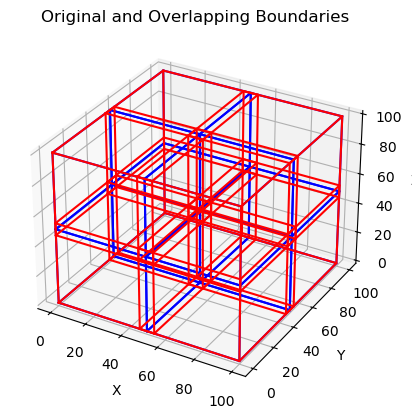

In [43]:
# Draw combined boundaries in 3D
draw_combined_boundaries_in_3d(cubes, overlapping_cubes)

In [44]:
import tifffile
import numpy as np


# Method 1: Using tifffile
original_image = tifffile.imread(r'G:\Alexis_data\Project\FISH\input\Heart2_round3_DAPI_resliced-q1-z1_cp_masks.tif')

# Print image shape and data type
print(f"Image shape: {original_image.shape}")
print(f"Data type: {original_image.dtype}")

# Display basic statistics
print(f"Min value: {np.min(original_image)}")
print(f"Max value: {np.max(original_image)}")
print(f"Mean value: {np.mean(original_image)}")

Image shape: (390, 1164, 1024)
Data type: uint16
Min value: 0
Max value: 15334
Mean value: 367.99247905110377


In [46]:
# Example usage
# original_image = tiff.imread("path_to_your_3d_tif_file.tif")
cubic_size = 390
overlap = 100
image = data
cubes, overlapping_cubes = crop_array_to_overlapping_cubes(original_image, cubic_size, overlap)

print(f"Number of original cubes: {len(cubes)}")
for i, (cube, boundaries) in enumerate(cubes[:8]):  # Display the first few original cubes
    print(f"Original Cube {i} shape: {cube.shape}, Boundaries: {boundaries}")

print(f"Number of overlapping cubes: {len(overlapping_cubes)}")
for i, (cube_overlap, boundaries) in enumerate(overlapping_cubes[:8]):  # Display the first few overlapping cubes
    print(f"Overlapping Cube {i} shape: {cube_overlap.shape}, Boundaries: {boundaries}")

Number of original cubes: 4
Original Cube 0 shape: (390, 390, 390), Boundaries: [0, 390, 0, 390, 0, 390]
Original Cube 1 shape: (390, 390, 390), Boundaries: [0, 390, 0, 390, 390, 780]
Original Cube 2 shape: (390, 390, 390), Boundaries: [0, 390, 390, 780, 0, 390]
Original Cube 3 shape: (390, 390, 390), Boundaries: [0, 390, 390, 780, 390, 780]
Number of overlapping cubes: 4
Overlapping Cube 0 shape: (390, 490, 490), Boundaries: [0, 390, 0, 490, 0, 490]
Overlapping Cube 1 shape: (390, 490, 590), Boundaries: [0, 390, 0, 490, 290, 880]
Overlapping Cube 2 shape: (390, 590, 490), Boundaries: [0, 390, 290, 880, 0, 490]
Overlapping Cube 3 shape: (390, 590, 590), Boundaries: [0, 390, 290, 880, 290, 880]


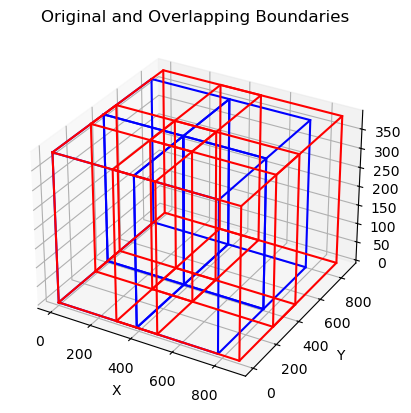

In [47]:
# Draw combined boundaries in 3D
draw_combined_boundaries_in_3d(cubes, overlapping_cubes)

In [28]:
# Save the cubes as TIFF files
def save_cubes_as_tiff(cubes, base_filename):
    """
    Saves each cube as a separate TIFF file.

    Args:
        cubes (List[Tuple[np.ndarray, List[int]]]): List of cubes and their boundaries.
        base_filename (str): Base filename for saving the TIFF files.
    """
    for i, (cube, boundaries) in enumerate(cubes):
        filename = f"{base_filename}_cube_{i}.tif"
        tifffile.imwrite(filename, cube)
        print(f"Saved: {filename}")
        
save_cubes_as_tiff(overlapping_cubes, base_filename="G:/Alexis_data/Project/FISH/output/overlapping_cube")

Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_0.tif
Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_1.tif
Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_2.tif
Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_3.tif
Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_4.tif
Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_5.tif
Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_6.tif
Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_7.tif
Saved: G:/Alexis_data/Project/FISH/output/overlapping_cube_cube_8.tif
